In [171]:
import pandas as pd
import osmnx as ox
import ast

# Load the nodes files
complete_nodes = pd.read_csv("nodes_complete.csv", sep=";")
incomplete_nodes = pd.read_csv("bologna_nodes_p.csv", sep=";")



# Load the edges files
complete_edges = pd.read_csv("edges_complete.csv", sep=";")
incomplete_edges = pd.read_csv("bologna_edges_p.csv", sep=";")




# Define residential flags
FLAGS_RESIDENTIAL = [
    "residential",
    "living_street",
    "unclassified",
    "service",
    "pedestrian",
    "busway",
]

# Filter the complete edges for residential streets
residential_streets = complete_edges[complete_edges["highway"].isin(FLAGS_RESIDENTIAL)]
print(len(residential_streets))

# Extract all nodes (u and v) from the incomplete graph
incomplete_nodes_set = set(incomplete_nodes["osmid_original"])
print(len(incomplete_nodes_set))




#                    ---------------------------- ADDING STREETS --------------------------------



listine=0
valorini=0

streets_to_add = []

for _, row in residential_streets.iterrows():
    u, v = row["u_original"], row["v_original"]
    found_match = False

    for index, row_nodes in complete_nodes.iterrows():
    # if "osmid_original" is a list, keep the first element
        old_list = ast.literal_eval(str(row_nodes["osmid_original"]))
        if isinstance(old_list, list):
            if (u in old_list) or (v in old_list):
                for index in incomplete_nodes_set:
                    if index in old_list:
                        found_match = True
                        if u in old_list:
                            row["u_original"] = index 
                        if v in old_list:
                            row["v_original"] = index
                        listine += 1 
                        break 
        else:
            if u == old_list or v == old_list:
                for index in incomplete_nodes_set:
                    if u == index or v == index:
                        found_match = True
                        valorini += 1
                    

        if found_match:
            break

        
    if found_match:
        streets_to_add.append(row.to_dict())


print('liste=' , listine, 'valori=' , valorini)



# Create a DataFrame for new edges and append it to the incomplete edges
new_streets = pd.DataFrame(streets_to_add)
print(new_streets)



updated_incomplete_edges = pd.concat([incomplete_edges, new_streets], ignore_index=True)
updated_incomplete_edges = updated_incomplete_edges.drop_duplicates(subset=["u_original", "v_original"])



#                    ---------------------------- ADDING NODES --------------------------------




# Extract all unique nodes used in the updated edges
# Convert columns to string and combine their sets
updated_nodes_set = (
    set(updated_incomplete_edges["u_original"].map(str))
    .union(updated_incomplete_edges["v_original"].map(str))
    - set(incomplete_nodes["osmid_original"].map(str))
)



nodes_to_add = []
for index, row in complete_nodes.iterrows():
    value = ast.literal_eval(str(row["osmid_original"]))
    
    if isinstance(value, list):
        for id in updated_nodes_set:
            if int(id) in value:
                copy = row.copy()
                copy["osmid_original"] = id
                copy["highway"] = 'in_out'
                nodes_to_add.append(copy.to_dict())
    else:
        if str(value) in updated_nodes_set:
            row["highway"] = 'in_out'
            nodes_to_add.append(row.to_dict())

new_nodes = pd.DataFrame(nodes_to_add)
print(new_nodes)

updated_nodes = pd.concat([incomplete_nodes, new_nodes])


# Set the columns

updated_incomplete_edges = updated_incomplete_edges[
         ["u_original", "v_original", "length", "oneway", "lanes", "highway", "maxspeed", "name", "geometry"]
     ]
updated_nodes = updated_nodes[["osmid_original", "x", "y", "highway", "geometry"]]





# Save the file


updated_incomplete_edges.to_csv("bologna_edges.csv", index=False, sep=";")

updated_nodes.to_csv("processed_nodes.csv", index=False, sep=";")

print("Updated nodes and edges files have been created.")
print(len(updated_nodes))


3526
731
liste= 366 valori= 74
        u     v  key                 osmid  oneway lanes  ref  \
0       7    68    0              22880349    True     1  NaN   
1      67    69    0  [32210212, 32210207]    True   NaN  NaN   
2      12    13    0              95408276    True   NaN  NaN   
3      16    18    0             455333827    True   NaN  NaN   
4      17   311    0             422655697   False   NaN  NaN   
..    ...   ...  ...                   ...     ...   ...  ...   
435  2578  2580    0             489667639    True   NaN  NaN   
436  2578  2581    0             122233079   False   NaN  NaN   
437  2612   898    0             142994312    True   NaN  NaN   
438  2799  2667    0             381719637   False   NaN  NaN   
439  2800  2667    0             381966595   False   NaN  NaN   

                                               name        highway  \
0                                    Via Mascarella    residential   
1    ['Via Mentana', 'Via del Borgo di San Pietr

In [172]:
from shapely import wkt
import geopandas as gpd

updated_nodes["geometry"] = updated_nodes["geometry"].apply(wkt.loads)
updated_incomplete_edges["geometry"] = updated_incomplete_edges["geometry"].apply(wkt.loads)

updated_nodes = gpd.GeoDataFrame(updated_nodes, geometry="geometry")
updated_incomplete_edges = gpd.GeoDataFrame(updated_incomplete_edges, geometry="geometry")
updated_nodes = updated_nodes.set_geometry("geometry")
updated_incomplete_edges = updated_incomplete_edges.set_geometry("geometry")




In [173]:
from shapely.geometry import Point

updated_nodes["geometry"] = updated_nodes.apply(lambda row: Point(row["x"], row["y"]), axis=1)
assert updated_nodes.crs == updated_incomplete_edges.crs, "CRS mismatch between nodes and edges"

if not isinstance(updated_incomplete_edges.index, pd.MultiIndex):
    updated_incomplete_edges.set_index(["u_original", "v_original", "lanes"], inplace=True)





In [174]:
if updated_nodes.crs is None:
    updated_nodes = updated_nodes.set_crs("EPSG:4326")

if updated_incomplete_edges.crs is None:
    updated_incomplete_edges = updated_incomplete_edges.set_crs("EPSG:4326")




graph2 = ox.graph_from_gdfs(updated_nodes, updated_incomplete_edges)



for node, out_degree in graph2.out_degree():
    in_degree = graph2.in_degree(node)
    if out_degree >= 0 and in_degree == 0 :
        updated_nodes.loc[updated_nodes['osmid_original'] == node, 'highway'] = 'outgoing_only'
    elif in_degree >= 0 and out_degree == 0 :
        updated_nodes.loc[updated_nodes['osmid_original'] == node, 'highway'] = 'ingoing_only'
        
updated_incomplete_edges.reset_index(inplace=True)



#   Save the files but bolo.cpp does not accept edges 


updated_nodes.to_csv("bologna_nodes.csv", index=False, sep=";")


NOT WORKING

1036


ValueError: setting an array element with a sequence.

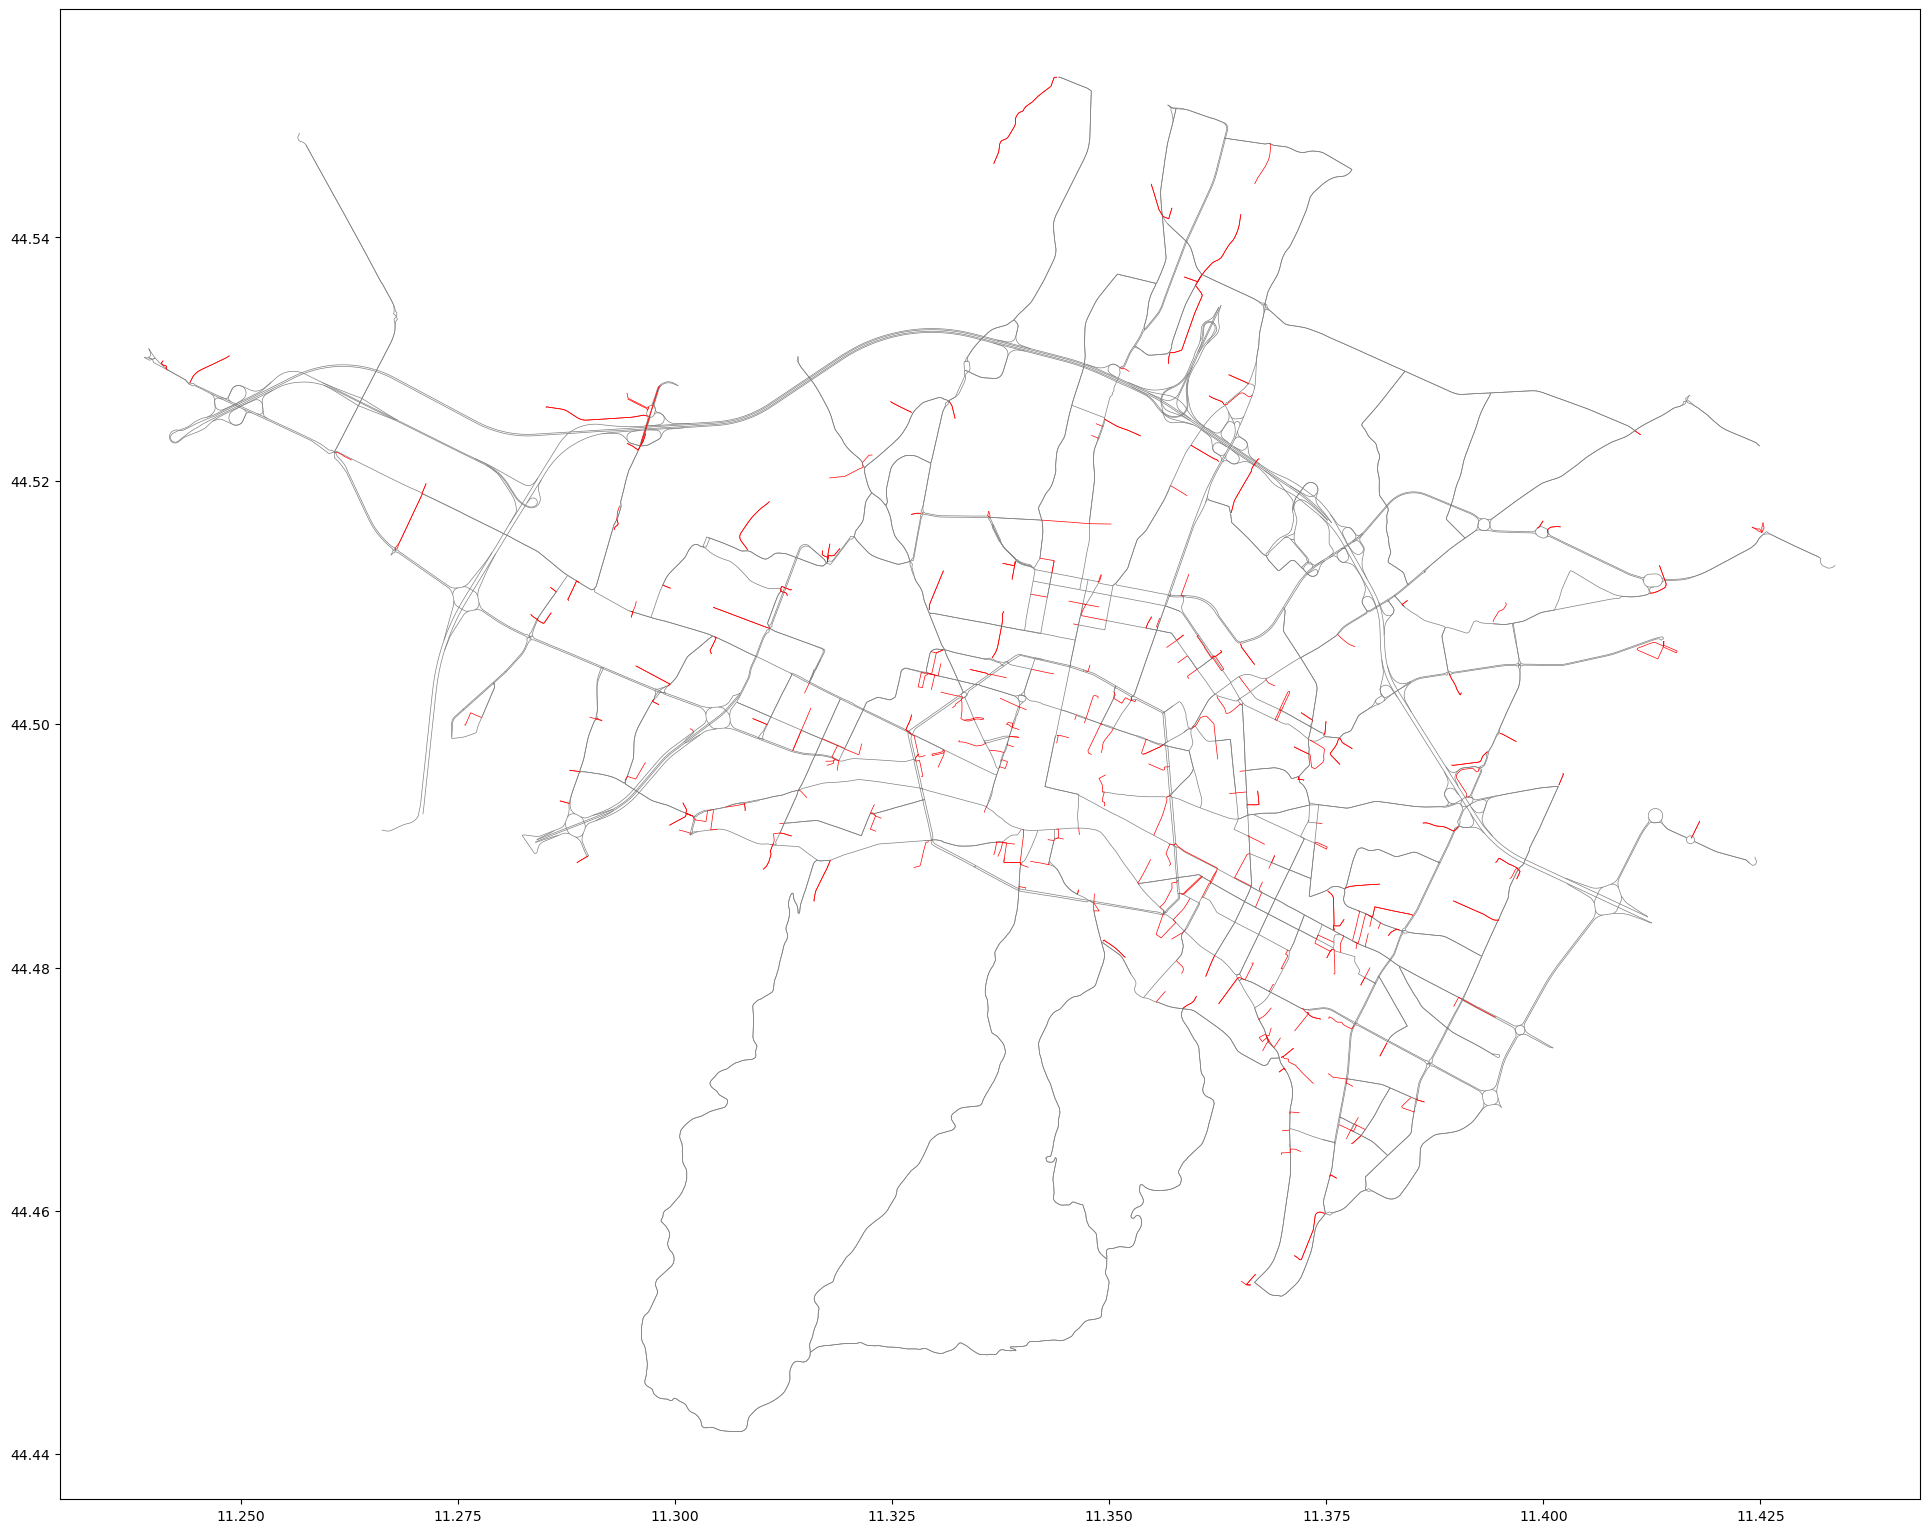

In [175]:
import matplotlib.pyplot as plt


#  -   -   -   -  -   -   -   -   -   -   -   -   -   -   -   -   -   NOT WORKING   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   



# Extract edge data and color based on the "highway" attribute
edge_colors = []
for u, v, data in graph2.edges(data=True):
    if data.get("highway") in ['residential', 'living_street', 'unclassified', 'service', 'pedestrian', 'busway']:
        edge_colors.append("red")
    else:
        edge_colors.append("gray")

# Initialize node colors and sizes
node_colors = []
node_sizes = []

# Iterate through the nodes in graph2
for node, data in graph2.nodes(data=True):
    # Check if the node exists in updated_nodes
    match = updated_nodes.loc[updated_nodes['osmid_original'] == node]
    
    if not match.empty:
        # Get the node status
        node_status = match['highway'].values[0]
        
        if node_status in ['outgoing_only', 'ingoing_only', 'in_out']:
            node_colors.append("violet")  # Special nodes
            node_sizes.append(30)  # Larger size
        else:
            node_colors.append("black")  # Default nodes
            node_sizes.append(15)  # Default size
    else:
        # If no match is found, default attributes
        node_colors.append("black")
        node_sizes.append(15)

print(len(updated_nodes))

# Plot the graph with custom node and edge attributes
fig, ax = ox.plot_graph(
    graph2,
    edge_color=edge_colors,
    node_size=node_sizes,  # Custom node sizes
    node_color="black",  # Custom node colors
    bgcolor="white",  # Background color
    edge_linewidth=0.5,  # Edge line width
    figsize=(24, 24),
    show=True,
    save=True  # Save the plot if needed
)
